# Alchemical PES and their errors


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['font.size'] = 12

from apdft_tools.utils import *
from apdft_tools.utils import _remove_dimer_outliers, _dimer_poly_pred
from apdft_tools.data import prepare_dfs
from apdft_tools.prediction import *

json_path = '../../json-data/dimer-pyscf.apdft-data.posthf.json'
df_qc, df_apdft = prepare_dfs(json_path, get_CBS=False)

## Alchemical PES errors with respect to QC

Specifies the system of interest.

In [2]:
basis_set = 'cc-pV5Z'
specific_atom = 0

n_points = 2
poly_order = 4

qm_color = '#577590'

Alchemical error wrt QC
        n.h       b.h
0 -0.137232  0.544312


/home/alex/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


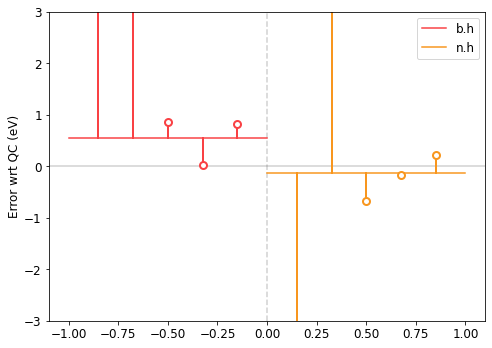

In [3]:
system_label = 'c.h'
system_charge = 0
excitation_level = 0
plot_apdft_orders = [0, 1, 2, 3, 4]
considered_lambdas = [-1, 1]

bl_eq_qc, e_eq_qc = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type='qc',
    use_fin_diff=None, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)

bl_eq_pred_alchemy, e_eq_pred_alchemy = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type='alchemy',
    use_fin_diff=False, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)
bl_eq_pred_apdft, e_eq_pred_apdft = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type='alchemy',
    use_fin_diff=True, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)

atomic_numbers_target = system_to_atomic_numbers(system_label)
atomic_numbers_refs = {key: system_to_atomic_numbers(key) for key in e_eq_pred_alchemy.keys()}
lambda_values_refs = {
    key: get_lambda_value(atomic_numbers_target, value, specific_atom=0) for key,value in atomic_numbers_refs.items()
}

e_ref = e_eq_qc[system_label]
e_eq_pred_alchemy_error_qc = {key:hartree_to_ev(value-e_ref) for key,value in e_eq_pred_alchemy.items()}
e_eq_pred_apdft_error_qc = {key:hartree_to_ev(value-e_ref) for key,value in e_eq_pred_apdft.items()}

print('Alchemical error wrt QC')
print(pd.DataFrame(e_eq_pred_alchemy_error_qc))



###   FIGURE   ###
lolli_line_width = 2
yaxis_max = 3
marker_size = 7
edge_buffer = 0.15
colors = ['#F94144', '#F8961E', '#43AA8B', '#577590', '#F9C74F']

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

ax.axhline(color='dimgrey', linestyle='-', alpha=0.3)
ax.axvline(color='dimgrey', linestyle='--', alpha=0.3)


i_color = 0
sys_keys_sorted = list(e_eq_pred_apdft_error_qc.keys())
sys_keys_sorted.sort()
for key in sys_keys_sorted:
    lambda_value = lambda_values_refs[key]
    alchemy_error_qc = e_eq_pred_alchemy_error_qc[key]
    apdft_error_qc = e_eq_pred_apdft_error_qc[key]
    color = colors[i_color]
    
    # Alchemical error line
    if lambda_value < 0:
        x_alchemical = [lambda_value, lambda_value+1]
    else:
        x_alchemical = [lambda_value-1, lambda_value]
    
    ax.plot(
        x_alchemical, [alchemy_error_qc, alchemy_error_qc],
        marker='', color=color, label=key
    )
    
    # APDFT error lollipop
    x_apdft = np.linspace(x_alchemical[0] + edge_buffer, x_alchemical[1] - edge_buffer, num=len(plot_apdft_orders))
    apdft_error_qc = apdft_error_qc[plot_apdft_orders]
    
    for i in range(len(plot_apdft_orders)):
        ax.plot(
            [x_apdft[i], x_apdft[i]], [alchemy_error_qc, apdft_error_qc[i]],
            marker='', markersize=0, 
            linestyle='-', linewidth=lolli_line_width,
            color=color
        )
        ax.plot(
            x_apdft[i], apdft_error_qc[i],
            marker='o', markersize=marker_size, markeredgewidth=lolli_line_width,
            linestyle='', linewidth=0,
            color=color, markerfacecolor='white'
        )
    
    i_color += 1

ax.set_ylabel('Error wrt QC (eV)')
ax.set_ylim((-yaxis_max, yaxis_max))

ax.legend()

Alchemical error wrt QC
        n.h       b.h
0 -0.160447  0.540402


/home/alex/.local/lib/python3.8/site-packages/apdft_tools/prediction.py:609: RankWarning: Polyfit may be poorly conditioned
  bond_lengths_fit, poly_coeffs = fit_dimer_poly(
/home/alex/.local/lib/python3.8/site-packages/apdft_tools/prediction.py:609: RankWarning: Polyfit may be poorly conditioned
  bond_lengths_fit, poly_coeffs = fit_dimer_poly(
/home/alex/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


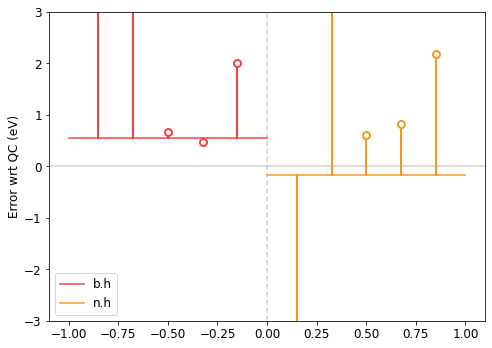

In [4]:
system_label = 'c.h'
system_charge = 1
excitation_level = 0
plot_apdft_orders = [0, 1, 2, 3, 4]
considered_lambdas = [-1, 1]

bl_eq_qc, e_eq_qc = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type='qc',
    use_fin_diff=None, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)

bl_eq_pred_alchemy, e_eq_pred_alchemy = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type='alchemy',
    use_fin_diff=False, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)
bl_eq_pred_apdft, e_eq_pred_apdft = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type='alchemy',
    use_fin_diff=True, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)

atomic_numbers_target = system_to_atomic_numbers(system_label)
atomic_numbers_refs = {key: system_to_atomic_numbers(key) for key in e_eq_pred_alchemy.keys()}
lambda_values_refs = {
    key: get_lambda_value(atomic_numbers_target, value, specific_atom=0) for key,value in atomic_numbers_refs.items()
}

e_ref = e_eq_qc[system_label]
e_eq_pred_alchemy_error_qc = {key:hartree_to_ev(value-e_ref) for key,value in e_eq_pred_alchemy.items()}
e_eq_pred_apdft_error_qc = {key:hartree_to_ev(value-e_ref) for key,value in e_eq_pred_apdft.items()}

print('Alchemical error wrt QC')
print(pd.DataFrame(e_eq_pred_alchemy_error_qc))

###   FIGURE   ###
lolli_line_width = 2
yaxis_max = 3
marker_size = 7
edge_buffer = 0.15
colors = ['#F94144', '#F8961E', '#43AA8B', '#577590']

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

ax.axhline(color='dimgrey', linestyle='-', alpha=0.3)
ax.axvline(color='dimgrey', linestyle='--', alpha=0.3)


i_color = 0
sys_keys_sorted = list(e_eq_pred_apdft_error_qc.keys())
sys_keys_sorted.sort()
for key in sys_keys_sorted:
    lambda_value = lambda_values_refs[key]
    alchemy_error_qc = e_eq_pred_alchemy_error_qc[key]
    apdft_error_qc = e_eq_pred_apdft_error_qc[key]
    color = colors[i_color]
    
    # Alchemical error line
    if lambda_value < 0:
        x_alchemical = [lambda_value, lambda_value+1]
    else:
        x_alchemical = [lambda_value-1, lambda_value]
    
    ax.plot(
        x_alchemical, [alchemy_error_qc, alchemy_error_qc],
        marker='', color=color, label=key
    )
    
    # APDFT error lollipop
    x_apdft = np.linspace(x_alchemical[0] + edge_buffer, x_alchemical[1] - edge_buffer, num=len(plot_apdft_orders))
    apdft_error_qc = apdft_error_qc[plot_apdft_orders]
    
    for i in range(len(plot_apdft_orders)):
        ax.plot(
            [x_apdft[i], x_apdft[i]], [alchemy_error_qc, apdft_error_qc[i]],
            marker='', markersize=0, 
            linestyle='-', linewidth=lolli_line_width,
            color=color
        )
        ax.plot(
            x_apdft[i], apdft_error_qc[i],
            marker='o', markersize=marker_size, markeredgewidth=lolli_line_width,
            linestyle='', linewidth=0,
            color=color, markerfacecolor='white'
        )
    
    i_color += 1

ax.set_ylabel('Error wrt QC (eV)')
ax.set_ylim((-yaxis_max, yaxis_max))

ax.legend()

In [5]:
system_label = 'c.h'
delta_charge = 1
target_initial_charge = 0  # Initial charge of the system.
basis_set = 'cc-pV5Z'
lambda_specific_atom = 0
change_signs = False  # Multiple all predictions by negative one (e.g., for electron affinities)


use_fin_diff = False  # Use finite differences with Taylor series for APDFT predictions.
remove_outliers = False

ie_qc_prediction = get_qc_change_charge_dimer(
    df_qc, system_label, delta_charge,
    target_initial_charge=target_initial_charge,
    change_signs=change_signs, basis_set=basis_set,
    n_points=n_points, poly_order=poly_order, remove_outliers=remove_outliers
)
ie_apdft_predictions = get_apdft_change_charge_dimer(
    df_qc, df_apdft, system_label, delta_charge,
    target_initial_charge=target_initial_charge,
    change_signs=change_signs, basis_set=basis_set,
    use_fin_diff=use_fin_diff, lambda_specific_atom=lambda_specific_atom,
    n_points=n_points, poly_order=poly_order, remove_outliers=remove_outliers
)

ie_qc_prediction = hartree_to_ev(ie_qc_prediction)
ie_apdft_predictions = {key:hartree_to_ev(value) for key,value in ie_apdft_predictions.items()}
ie_apdft_errors = {key:value-ie_qc_prediction for key,value in ie_apdft_predictions.items()}

print(f'PySCF prediction of IE for {system_label}: {ie_qc_prediction:.3f} eV\n')
if use_fin_diff:
    print(f'APDFTn prediction errors in eV:')
    print(pd.DataFrame(ie_apdft_errors, index=[f'APDFT{n}' for n in range(5)]))
else:
    print(f'Alchemical prediction errors in eV:')
    print(pd.DataFrame(ie_apdft_errors, index=[f'Alchemy']))

PySCF prediction of IE for c.h: 10.625 eV

Alchemical prediction errors in eV:
              n.h      b.h
Alchemy -0.023215 -0.00391


$$
\Delta E = \Delta E_{+1} - \Delta E_{0}
$$

$$
\Delta E = \Delta E_{+1} + error_{+1} - \Delta E_{0} - error_{0}
$$

$$
\Delta E = (\Delta E_{+1} - \Delta E_{0}) + (error_{+1} - error_{0})
$$